#### Training loop

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class SpectrogramPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # Predicts [distance, azimuth, elevation]

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute TDoA from spectrogram phase differences
def compute_tdoa_spectro(spectrograms, fs=16000):
    phase_diffs = np.angle(spectrograms[:, :, 1:]) - np.angle(spectrograms[:, :, :-1])
    tdoa_values = np.unwrap(phase_diffs, axis=-1) / (2 * np.pi * fs)
    return tdoa_values

# Generate synthetic spectrogram data (Placeholder - replace with actual data)
num_samples = 500
num_mics = 6
spectrogram_shape = (num_samples, num_mics, 128, 128)
synthetic_spectrograms = np.random.rand(*spectrogram_shape) + 1j * np.random.rand(*spectrogram_shape)
tdoa_values = compute_tdoa_spectro(synthetic_spectrograms)

targets = np.random.rand(num_samples, 3)  # (distance, azimuth, elevation)

# Normalize inputs and targets
spectrograms_normalized = (np.abs(synthetic_spectrograms) - np.mean(np.abs(synthetic_spectrograms))) / np.std(np.abs(synthetic_spectrograms))
targets_normalized = (targets - np.mean(targets, axis=0)) / np.std(targets, axis=0)

# Convert to tensors
X_train = torch.tensor(spectrograms_normalized, dtype=torch.float32)
y_train = torch.tensor(targets_normalized, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model setup
model = SpectrogramPINN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train(model, dataloader, epochs=25):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)

print("Starting training...")
train(model, dataloader)


Starting training...
Epoch 1/25, Loss: 20.1365
Epoch 2/25, Loss: 1.0073
Epoch 3/25, Loss: 1.0006
Epoch 4/25, Loss: 0.9891
Epoch 5/25, Loss: 0.9767
Epoch 6/25, Loss: 0.9261
Epoch 7/25, Loss: 0.8986
Epoch 8/25, Loss: 0.8296
Epoch 9/25, Loss: 0.8083
Epoch 10/25, Loss: 0.7007
Epoch 11/25, Loss: 0.6154
Epoch 12/25, Loss: 0.5217
Epoch 13/25, Loss: 0.4287
Epoch 14/25, Loss: 0.3725
Epoch 15/25, Loss: 0.2790
Epoch 16/25, Loss: 0.2235
Epoch 17/25, Loss: 0.1564
Epoch 18/25, Loss: 0.1023
Epoch 19/25, Loss: 0.0677
Epoch 20/25, Loss: 0.0391
Epoch 21/25, Loss: 0.0233
Epoch 22/25, Loss: 0.0142
Epoch 23/25, Loss: 0.0082
Epoch 24/25, Loss: 0.0058
Epoch 25/25, Loss: 0.0029


#### Evaluation

In [65]:
def evaluate(model, dataloader):
    model.eval()
    distance_errors, azimuth_errors, elevation_errors = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            y_pred = model(X_batch)
            errors = torch.abs(y_pred - y_batch)
            distance_errors.extend(errors[:, 0].tolist())
            azimuth_errors.extend(errors[:, 1].tolist())
            elevation_errors.extend(errors[:, 2].tolist())
    print(f"Mean Distance Error: {np.mean(distance_errors):.2f} m")
    print(f"Mean Azimuth Error: {np.mean(azimuth_errors):.2f}°")
    print(f"Mean Elevation Error: {np.mean(elevation_errors):.2f}°")

evaluate(model, dataloader)

Mean Distance Error: 0.05 m
Mean Azimuth Error: 0.02°
Mean Elevation Error: 0.03°


In [68]:
import numpy as np
import torch

def evaluate_model(model, dataloader, distance_threshold=1.0, angular_threshold=5.0):
    model.eval()
    distance_errors = []
    azimuth_errors = []
    elevation_errors = []
    pos_errors = []
    correct_distances = 0
    correct_azimuths = 0
    correct_elevations = 0
    correct_positions = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            y_pred = model(X_batch)
            
            # Distance error (meters)
            distance_error = torch.abs(y_pred[:, 0] - y_batch[:, 0])
            distance_errors.extend(distance_error.tolist())
            correct_distances += (distance_error < distance_threshold).sum().item()
            
            # Angular errors (degrees)
            azimuth_error = torch.abs(y_pred[:, 1] - y_batch[:, 1]).mul(180/np.pi)
            azimuth_errors.extend(azimuth_error.tolist())
            correct_azimuths += (azimuth_error < angular_threshold).sum().item()
            
            elevation_error = torch.abs(y_pred[:, 2] - y_batch[:, 2]).mul(180/np.pi)
            elevation_errors.extend(elevation_error.tolist())
            correct_elevations += (elevation_error < angular_threshold).sum().item()
            
            # 3D position error (convert polar to Cartesian)
            def polar_to_cartesian(r, theta, phi):
                x = r * torch.cos(theta) * torch.cos(phi)
                y = r * torch.sin(theta) * torch.cos(phi)
                z = r * torch.sin(phi)
                return torch.stack([x, y, z], dim=1)
            
            pos_true = polar_to_cartesian(y_batch[:, 0], y_batch[:, 1], y_batch[:, 2])
            pos_pred = polar_to_cartesian(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])
            pos_error = torch.norm(pos_true - pos_pred, dim=1)
            pos_errors.extend(pos_error.tolist())
            correct_positions += (pos_error < distance_threshold).sum().item()
    
    # Calculate metrics
    num_samples = len(dataloader.dataset)
    metrics = {
        'Mean Distance Error (m)': np.mean(distance_errors),
        'Mean Azimuth Error (°)': np.mean(azimuth_errors),
        'Mean Elevation Error (°)': np.mean(elevation_errors),
        'Distance Accuracy (%)': (correct_distances / num_samples) * 100,
        'Azimuth Accuracy (%)': (correct_azimuths / num_samples) * 100,
        'Elevation Accuracy (%)': (correct_elevations / num_samples) * 100,
    }
    
    return metrics

# Example usage
print("Evaluating model...")
metrics = evaluate_model(model, dataloader)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluating model...
Mean Distance Error (m): 0.0457
Mean Azimuth Error (°): 1.1225
Mean Elevation Error (°): 1.9339
Distance Accuracy (%): 100.0000
Azimuth Accuracy (%): 99.6000
Elevation Accuracy (%): 95.8000


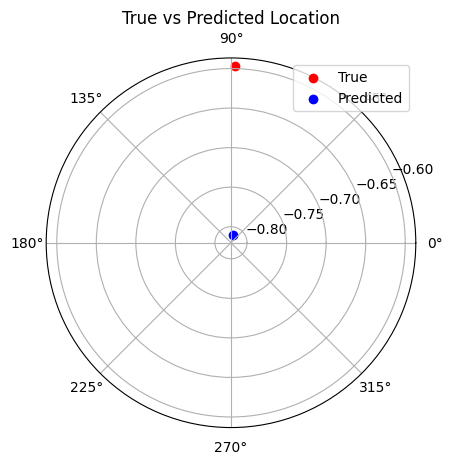

In [63]:
def plot_sample(model, dataset, idx=0):
    X, y_true = dataset[idx]
    with torch.no_grad():
        y_pred = model(X.unsqueeze(0))  
    
    
    # Polar coordinates
    plt.subplot(1, 1, 1, polar=True)
    plt.scatter(y_true[1].item(), y_true[0].item(), c='r', label="True")
    plt.scatter(y_pred[0,1].item(), y_pred[0,0].item(), c='b', label="Predicted")
    plt.legend()
    plt.title("True vs Predicted Location")
    plt.show()

plot_sample(model, dataset)